In [2]:
import pandas as pd

data = pd.read_csv("../data/quotes_ETH.csv")

# Calculate moving averages for price (7-day, 30-day)
data['price_ma_7d'] = data['price'].rolling(window=7).mean()
data['price_ma_30d'] = data['price'].rolling(window=30).mean()

# Compute rolling standard deviations for percentage changes
data['volatility_1h'] = data['percent_change_1h'].rolling(window=7).std()
data['volatility_24h'] = data['percent_change_24h'].rolling(window=7).std()
data['volatility_7d'] = data['percent_change_7d'].rolling(window=7).std()

# Price-to-volume ratio
data['price_to_volume'] = data['price'] / data['volume_24h']

# Momentum features
data['momentum_1h'] = data['percent_change_1h'].diff()
data['momentum_24h'] = data['percent_change_24h'].diff()
data['momentum_7d'] = data['percent_change_7d'].diff()

data.head(10)

,Unnamed: 0,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,price,volume_24h,market_cap,total_supply,circulating_supply,timestamp,price_ma_7d,price_ma_30d,volatility_1h,volatility_24h,volatility_7d,price_to_volume,momentum_1h,momentum_24h,momentum_7d
0,0,-0.867704,2.155139,-1.989964,-12.487889,2333.634858,1.558047e+10,2.808332e+11,1.203415e+08,1.203415e+08,2024-09-17T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,1.497795e-07,NaN,NaN,NaN
1,1,-0.997112,-0.807570,-0.941806,-11.133973,2314.789132,1.720900e+10,2.785693e+11,1.203433e+08,1.203433e+08,2024-09-18T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,1.345104e-07,-0.129408,-2.962708,1.048158
2,2,-0.335070,6.713400,4.890830,-5.220049,2470.190192,1.929144e+10,2.972752e+11,1.203451e+08,1.203451e+08,2024-09-19T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,1.280459e-07,0.662042,7.520970,5.832636
3,3,0.105515,2.951267,5.023355,-3.794372,2543.092093,1.962865e+10,3.060508e+11,1.203459e+08,1.203459e+08,2024-09-20T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,1.295602e-07,0.440585,-3.762134,0.132525
4,4,0.019809,1.108439,6.706664,-1.475632,2571.280728,1.043495e+10,3.094459e+11,1.203470e+08,1.203470e+08,2024-09-21T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,2.464105e-07,-0.085706,-1.842827,1.683309
5,5,-0.279656,0.121911,8.388158,-6.265828,2574.415405,1.209269e+10,3.098261e+11,1.203481e+08,1.203481e+08,2024-09-22T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,2.128902e-07,-0.299464,-0.986528,1.681494
6,6,-0.248286,4.150505,17.372761,-4.087803,2681.266640,2.065218e+10,3.226897e+11,1.203497e+08,1.203497e+08,2024-09-23T19:50:00.000Z,2498.381293,NaN,0.416977,2.554610,6.439794,1.298297e-07,0.031369,4.028594,8.984603
7,7,0.347644,-1.335220,13.362458,-4.405311,2645.465838,1.618366e+10,3.184141e+11,1.203622e+08,1.203622e+08,2024-09-24T19:50:00.000Z,2542.928575,NaN,0.428924,2.912672,6.009802,1.634652e-07,0.595930,-5.485725,-4.010303
8,8,-0.165191,-2.616387,11.295245,-4.033416,2576.250226,1.476255e+10,3.100837e+11,1.203624e+08,1.203624e+08,2024-09-25T19:50:00.000Z,2580.280160,NaN,0.247573,3.247975,4.661974,1.745125e-07,-0.512835,-1.281167,-2.067214
9,9,0.447822,2.979921,7.401465,2.519738,2653.020459,1.719155e+10,3.193249e+11,1.203628e+08,1.203628e+08,2024-09-26T19:50:00.000Z,2606.398770,NaN,0.286550,2.481564,4.325813,1.543212e-07,0.613014,5.596308,-3.893779


In [4]:

# Drop rows with NaN values (due to shifts and rolling computations)
data_cleaned = data.drop(columns=['Unnamed: 0']).dropna()

# Feature selection (exclude the target and irrelevant columns)
features = data_cleaned.drop(columns=['price', 'timestamp', 'market_cap'])


In [5]:
# anomaly detection

import numpy as np
from sklearn.cluster import KMeans

# Fit KMeans clustering model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features)

# Assign cluster labels to data
data_cleaned['cluster'] = kmeans.labels_

# Calculate distances of each point to its cluster center
distances = np.linalg.norm(features - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Add distances to the dataset
data_cleaned['distance_to_center'] = distances

# Set a threshold for anomalies (e.g., top 5% of distances)
threshold = np.percentile(distances, 95)
data_cleaned['anomaly'] = data_cleaned['distance_to_center'] > threshold

data_cleaned.head()

,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,price,volume_24h,market_cap,total_supply,circulating_supply,timestamp,...,volatility_1h,volatility_24h,volatility_7d,price_to_volume,momentum_1h,momentum_24h,momentum_7d,cluster,distance_to_center,anomaly
29,-0.294012,0.940021,8.139508,14.394900,2613.240309,1.801267e+10,3.145981e+11,1.203862e+08,1.203862e+08,2024-10-16T19:50:00.000Z,...,0.420176,3.214697,3.322522,1.450779e-07,-0.218706,2.236435,1.938995,2,6.421816e+08,False
30,0.268589,-0.590030,9.987910,11.320818,2597.821405,1.516662e+10,3.127449e+11,1.203874e+08,1.203874e+08,2024-10-17T19:50:00.000Z,...,0.353813,2.970528,3.637622,1.712855e-07,0.562601,-1.530051,1.848402,2,2.203869e+09,False
31,-0.639479,2.074614,7.878286,14.555410,2651.716180,1.685667e+10,3.192348e+11,1.203880e+08,1.203880e+08,2024-10-18T19:50:00.000Z,...,0.371239,2.760466,3.285431,1.573096e-07,-0.908067,2.664644,-2.109625,2,5.138132e+08,False
32,0.011908,-0.377909,6.921755,6.942984,2641.695099,8.996273e+09,3.180288e+11,1.203881e+08,1.203881e+08,2024-10-19T19:50:00.000Z,...,0.368558,2.813202,3.003159,2.936433e-07,0.651387,-2.452524,-0.956531,2,8.374215e+09,False
33,-0.086070,2.121153,9.877018,6.080684,2697.729484,1.167084e+10,3.247783e+11,1.203895e+08,1.203895e+08,2024-10-20T19:50:00.000Z,...,0.292844,2.740360,1.430374,2.311513e-07,-0.097979,2.499062,2.955264,2,5.699647e+09,False


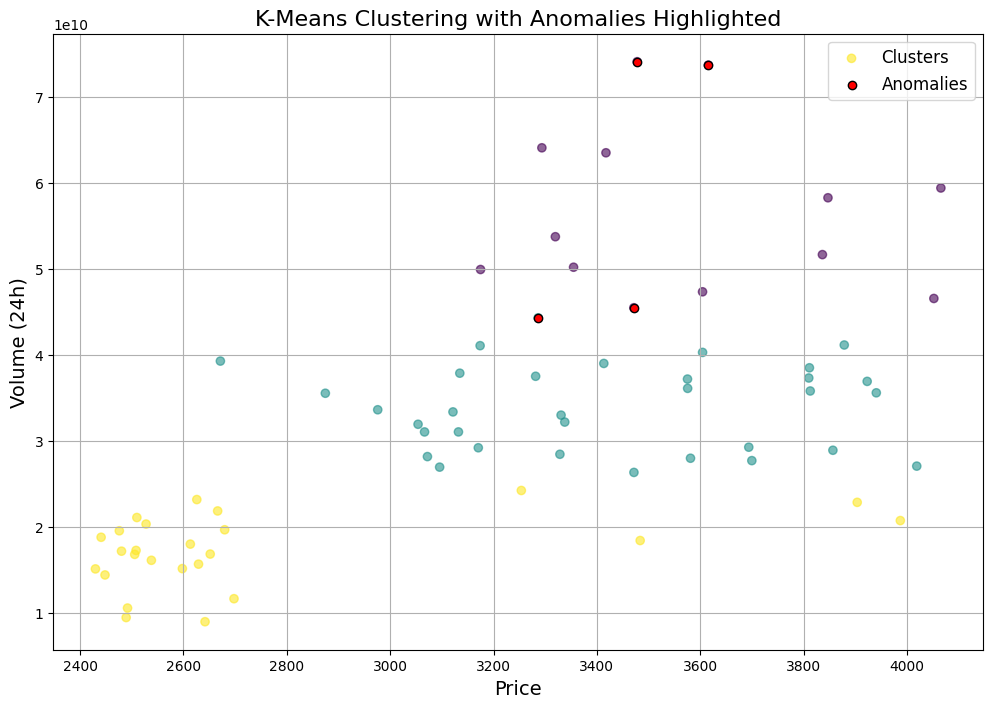

In [6]:
import matplotlib.pyplot as plt

# Scatter plot of clusters using price and volume_24h
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    data_cleaned['price'],
    data_cleaned['volume_24h'],
    c=data_cleaned['cluster'],  # Color by cluster
    cmap='viridis',
    alpha=0.6,
    label='Clusters'
)

# Highlight anomalies
anomalies = data_cleaned[data_cleaned['anomaly']]
plt.scatter(
    anomalies['price'],
    anomalies['volume_24h'],
    color='red',
    label='Anomalies',
    edgecolor='k'
)

# Add labels and legend
plt.title('K-Means Clustering with Anomalies Highlighted', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Volume (24h)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()

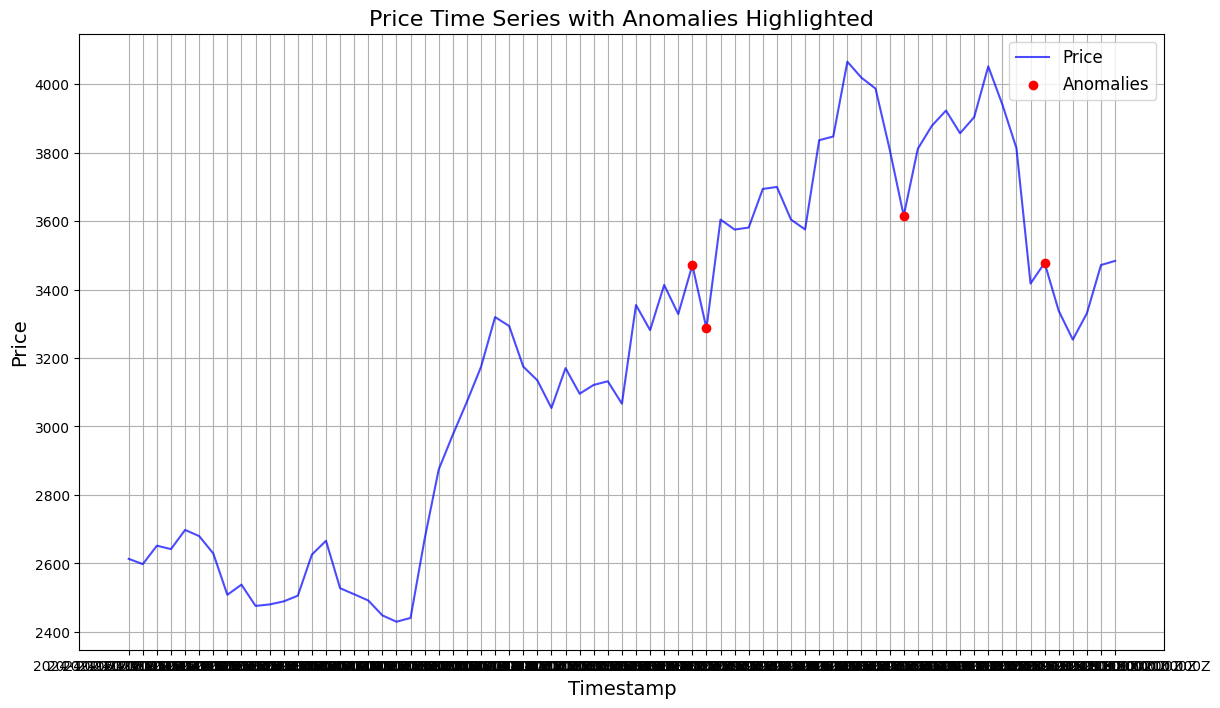

In [7]:
import matplotlib.pyplot as plt

# Plot time series of price
plt.figure(figsize=(14, 8))
plt.plot(data_cleaned['timestamp'], data_cleaned['price'], label='Price', color='blue', alpha=0.7)

# Highlight anomalies
anomalies = data_cleaned[data_cleaned['anomaly']]
plt.scatter(anomalies['timestamp'], anomalies['price'], color='red', label='Anomalies', zorder=5)

# Add titles and labels
plt.title('Price Time Series with Anomalies Highlighted', fontsize=16)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()